# Spatial Animations

Resolution: 1-degree, monthly average

---

In [16]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import data_utils as utils

In [3]:
# Colormap
# from matplotlib import colors
# from palettable.scientific.sequential import Oleron_20

# cm_sci = Oleron_20.mpl_colormap

# # NOTE: this is almost identical to jet
# nasa_palette = [
#     "#03006d","#02008f","#0000b6","#0001ef","#0000f6",
#     "#0428f6","#0b53f7","#0f81f3", "#18b1f5","#1ff0f7",
#     "#27fada","#3efaa3","#5dfc7b","#85fd4e","#aefc2a",
#     "#e9fc0d","#f6da0c","#f5a009", "#f6780a","#f34a09",
#     "#f2210a","#f50008","#d90009","#a80109","#730005"]

# cm_nasa = colors.LinearSegmentedColormap.from_list("nasa_palette", nasa_palette, N=256)

# offset = colors.TwoSlopeNorm(vcenter=0., vmin=-0.5, vmax=1.)

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [7]:
# Cut datasets to a regular grid and resample to monthly averages within each grid cell
DS_sif_monthly = (
    utils.regrid(DS_sif)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_xco2_monthly = (
    utils.regrid(DS_xco2)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

In [18]:
# Figure setup SIF
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(100, 100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.EqualEarth())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

offset = colors.TwoSlopeNorm(vcenter=0., vmin=-0.5, vmax=1.)

def animate(month, cmap):
    """Update contour with new frame (each frame should be a monthly group)"""
    da = DS_sif_monthly.sif.isel(time=month)
    
    ax.clear()
    cbar_ax.clear()
    
    ax.set_global()
    xarray.plot.imshow(da.T, ax=ax, cbar_ax=cbar_ax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap, extend="both", norm=offset, 
                        cbar_kwargs={
                            "orientation": "horizontal", 
                            "label": "Daily SIF 740nm [W/$m^2$/sr/$\mu$m]"
                        })
    
    ax.coastlines()
    ax.set_title(
    "OCO-2 SIF Lite: Daily SIF 740nm \n" 
    "QAflags=[0,1], 1-degree Monthly Average "
    f"{pd.to_datetime(da.time.values).strftime('%Y-%m-%d')}"
    )
    

mov = FuncAnimation(fig, animate, frames=DS_sif_monthly.time.size, 
                    interval=500, fargs=("jet", ))

HTML(mov.to_html5_video())
mov.save("../plots/Daily_SIF_740_1deg_monthly.mp4", fps=2, dpi=250)

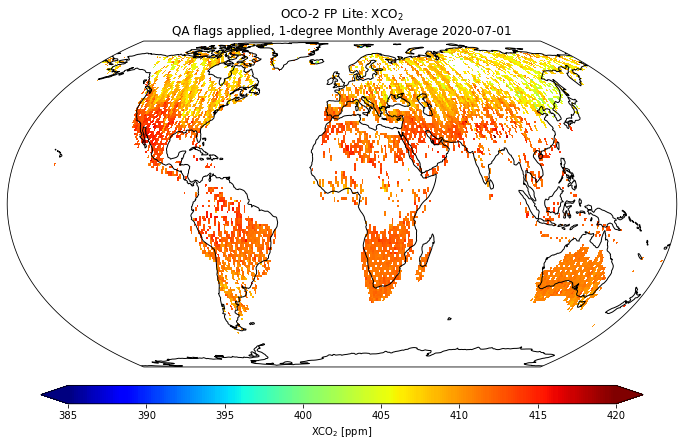

In [23]:
# Figure setup XCO2
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(100, 100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.EqualEarth())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

offset = colors.TwoSlopeNorm(vcenter=400, vmin=385, vmax=420)

def animate(month, cmap):
    """Update contour with new frame (each frame should be a monthly group)"""
    da = DS_xco2_monthly.xco2.isel(time=month)
    
    ax.clear()
    cbar_ax.clear()
    
    ax.set_global()
    xarray.plot.imshow(da.T, ax=ax, cbar_ax=cbar_ax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap, extend="both", norm=offset,
                        cbar_kwargs={
                            "orientation": "horizontal", 
                            "label": "XCO$_2$ [ppm]"
                        })
    
    ax.coastlines()
    ax.set_title(
    "OCO-2 FP Lite: XCO$_2$ \n" 
    "QA flags applied, 1-degree Monthly Average "
    f"{pd.to_datetime(da.time.values).strftime('%Y-%m-%d')}"
    )
    

mov = FuncAnimation(fig, animate, frames=DS_xco2_monthly.time.size, 
                    interval=500, fargs=("jet", ))

HTML(mov.to_html5_video())
mov.save("../plots/XCO2_1deg_monthly.mp4", fps=2, dpi=250);